# Modeling Cross Section Data with KNN, DT, and Random Forest

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
from joblib import dump, load

sns.set_style("white")

In [5]:
import sys
# This allows us to import the nucml utilities
sys.path.append("..")

import nucml.exfor.data_utilities as exfor_utils
import nucml.endf.data_utilities as endf_utils
import nucml.plot.plotting_utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
import nucml.model.model_building as model_utils
importlib.reload(exfor_utils)
importlib.reload(endf_utils)
importlib.reload(plot_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
importlib.reload(model_utils)
print("Finish importing scripts.")

Finish importing scripts.


In [6]:
figure_dir = "Figures/"

# Loading Normalized One-Hot Encoded Training, Validation, and Testing Datasets

In [7]:
df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(
    log=True, basic=0, num=True, low_en=True, filters=True)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: True
INFO:root: BASIC: 0
INFO:root: SCALER: STANDARD
INFO:root:Reading data from C:\Users\Pedro\Desktop\ML_Nuclear_Data\EXFOR\CSV_Files\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 10)
INFO:root:Dropping unnecessary features and one-hot encoding categorical columns...
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.


# ENDF Evaluation Cross Section Data for Chlorine (n,p) Reaction

These data points will serve to plot the current ENDFb5 data and compare it to the newly measured points along with the predictions

In [8]:
endf_cl = nuc_data.load_endf("Cl035", "MT103", log=True)
# endf_u  = nuc_data.load_endf("U233", "MT018", log=True)
# endf_u_nonelastic  = nuc_data.load_endf("U233", "MT003", log=True)

INFO:root:ENDF: Extracting data from C:\Users\Pedro\Desktop\ML_Nuclear_Data\Evaluated_Data\neutrons/Cl035/endfb8.0/tables/xs/n-Cl035-MT103.endfb8.0
INFO:root:ENDF: Converting MeV to eV...
INFO:root:ENDF: Converting mb to b...
INFO:root:ENDF: Finished. ENDF data contains 8791 datapoints.


# Importing Error Metrics and Loading ACE Energy Arrays

In [43]:
ace_u = ace_utils.get_energies("92233", ev=True, log=True)
ace_cl = ace_utils.get_energies("17035", ev=True, log=True, ace_dir="../ACE/acedata/")

# Importing Results CSV

In [10]:
knn_results = pd.read_csv("1_KNN/KNN_B0/knn_results.csv")
knn_results = knn_results.rename(columns={"id": "# of Nearest Neighbors"})
# knn_results = knn_results.rename(columns={"id": "# of Nearest Neighbors", "train_mae": "Train MAE", "test_mae":"Test MAE"})
knn_results = knn_results[~knn_results.model_path.str.startswith('C')]
knn_results_filtered = knn_results.drop_duplicates(keep="last")
knn_results_filtered.sort_values(by="test_mae")
knn_results_filtered = knn_results_filtered[knn_results_filtered.distance_type != "uniform"]

In [14]:
best_train_samples = knn_results_filtered[(knn_results_filtered.distance_metric == "euclidean") & 
                                          (knn_results_filtered.distance_type == "distance") & 
                                          (knn_results_filtered.normalizer == "power_yeo")]

best_train_samples_2 = knn_results_filtered[(knn_results_filtered.distance_metric == "manhattan") & 
                                            (knn_results_filtered.distance_type == "distance") & 
                                            (knn_results_filtered.normalizer == "power_yeo")]

best_test_samples = knn_results_filtered[(knn_results_filtered.distance_metric == "manhattan") & 
                                          (knn_results_filtered.distance_type == "distance") & 
                                          (knn_results_filtered.normalizer == "standard")]

In [23]:
path_to_best_train_model = best_train_samples[best_train_samples.train_mae == best_train_samples.train_mae.min()]["model_path"].values[0]
path_to_best_train_scaler = best_train_samples[best_train_samples.train_mae == best_train_samples.train_mae.min()]["scaler_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_train_model))
print("Loading scaler saved at: {}".format(path_to_best_train_scaler))
train_model_knn = load(path_to_best_train_model) 
train_scaler_knn = load(path_to_best_train_scaler)

Loading model saved at: E:\ML_Models_EXFOR\KNN_B0\k15_distance_euclidean_power_yeo_one_hot_B0_v2\k15_distance_euclidean_power_yeo_one_hot_B0_v2.joblib
Loading scaler saved at: E:\ML_Models_EXFOR\KNN_B0\k15_distance_euclidean_power_yeo_one_hot_B0_v2\scaler.pkl


In [12]:
dt_results = pd.read_csv("2_DT/DT_B0/dt_results.csv")

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
best_train_dt = dt_results[dt_results.train_mae == dt_results.train_mae.min()].drop_duplicates(keep="last")
best_test_dt = dt_results[dt_results.test_mae == dt_results.test_mae.min()].drop_duplicates(keep="last")

In [31]:
path_to_best_train_model = best_train_dt["model_path"].values[0]
path_to_best_train_scaler = best_train_dt["scaler_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_train_model))
print("Loading scaler saved at: {}".format(path_to_best_train_scaler))
train_model_dt = load(path_to_best_train_model) 
train_scaler_dt = load(path_to_best_train_scaler)

Loading model saved at: E:\ML_Models_EXFOR\DT_B0\DT310_MSS2_MSL1_standard_one_hot_B0_v2\DT310_MSS2_MSL1_standard_one_hot_B0_v2.joblib
Loading scaler saved at: E:\ML_Models_EXFOR\DT_B0\DT310_MSS2_MSL1_standard_one_hot_B0_v2\scaler.pkl


In [32]:
knn_scaler = train_scaler_knn
dt_scaler = train_scaler_dt

In [33]:
sns.set(font_scale=2)
sns.set_style('white')

# Sampling Chlorine (n,p) and U-233(n,f) Data for Visualization

The model will be trained in the entire data therefore getting the total MSE. As an example, we will see the model predictions for both the mentioned reactions. 

In [34]:
# kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": knn_scaler, "to_scale": to_scale}
kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "to_scale": to_scale}

chlorine_35_np_knn = exfor_utils.load_samples(df, 17, 35, "MT_103", scaler=knn_scaler, **kwargs)
chlorine_35_np_dt = exfor_utils.load_samples(df, 17, 35, "MT_103", scaler=dt_scaler, **kwargs)
# uranium_235_nt = exfor_utils.load_exfor_samples(df, 92, 235, "MT_1", **kwargs)
# uranium_233_nf = exfor_utils.load_exfor_samples(df, 92, 233, "MT_18", **kwargs)
# uranium_233_nt = exfor_utils.load_exfor_samples(df, 92, 233, "MT_1", one_hot=True)

Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 40)
Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (215, 40)


In [35]:
# kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "scaler": scaler, "to_scale": to_scale}
# uranium = exfor_utils.load_exfor_element(df, 92, **kwargs)

# Newly Measured Chlorine (n,p) Unseen Data 

These data points are not in the current EXFOR data package and will be used to test the new modeling capabilities.

In [36]:
# # new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":True, "scaler":scaler, "to_scale":to_scale}
# new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":True, "to_scale":to_scale}
# new_cl_data_knn = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=knn_scaler, **new_cl_data_kwargs)
# new_cl_data_dt = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=dt_scaler, **new_cl_data_kwargs)
# new_cl_data_dt.head()

new_cl_data_kwargs = {"Z":17, "A":35, "MT":"MT_103", "log":True, "scale":True, "to_scale":to_scale, "one_hot":True}
new_cl_data_knn = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=knn_scaler, **new_cl_data_kwargs)
new_cl_data_dt = exfor_utils.load_newdata("../EXFOR/New_Data/Chlorine_Data/new_cl_np.csv", df, scaler=dt_scaler, **new_cl_data_kwargs)
new_cl_data_dt.head()

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 40)
Scaling dataset...
Expanded Dataset has shape:  (12, 40)
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 40)
Scaling dataset...
Expanded Dataset has shape:  (12, 40)


,Energy,Data,Z,N,A,MT_1,MT_101,MT_102,MT_103,MT_104,...,MT_33,MT_4,MT_41,MT_51,MT_9000,MT_9001,Center_of_Mass_Flag_Center_of_Mass,Center_of_Mass_Flag_Lab,Element_Flag_I,Element_Flag_N
0,6.383815,-1.779892,-1.129329,-1.113937,-1.120223,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,6.383815,-1.707744,-1.129329,-1.113937,-1.120223,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
2,6.401401,-1.583359,-1.129329,-1.113937,-1.120223,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
3,6.401401,-1.590067,-1.129329,-1.113937,-1.120223,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4,6.411620,-1.350665,-1.129329,-1.113937,-1.120223,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


# Nearest Neighbors Regression

In [37]:
from matplotlib.ticker import MaxNLocator

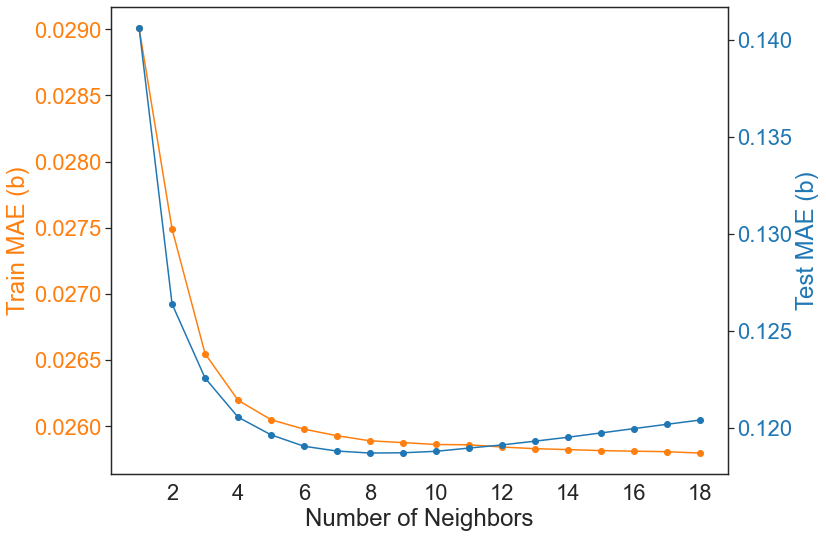

In [19]:
fig, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:orange'
ax1.set_xlabel('Number of Neighbors')
ax1.set_ylabel('Train MAE (b)', color=color)
ax1.plot(knn_results.id, knn_results.train_mae, color=color, marker="o", label="Train MAE")
ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(["fds"])


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Test MAE (b)', color=color)  # we already handled the x-label with ax1
ax2.plot(knn_results.id, knn_results.test_mae, color=color, marker="o", label="test")
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.legend(["Test"])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("knn_mae.png", bbox_inches="tight", dpi=400)
plt.show()

In [20]:
# plt.figure(figsize=(12,8))
# plt.scatter(dt_results.max_depth, dt_results.test_mae)
# plt.xlabel("Max Depth")
# plt.ylabel("Test MAE")

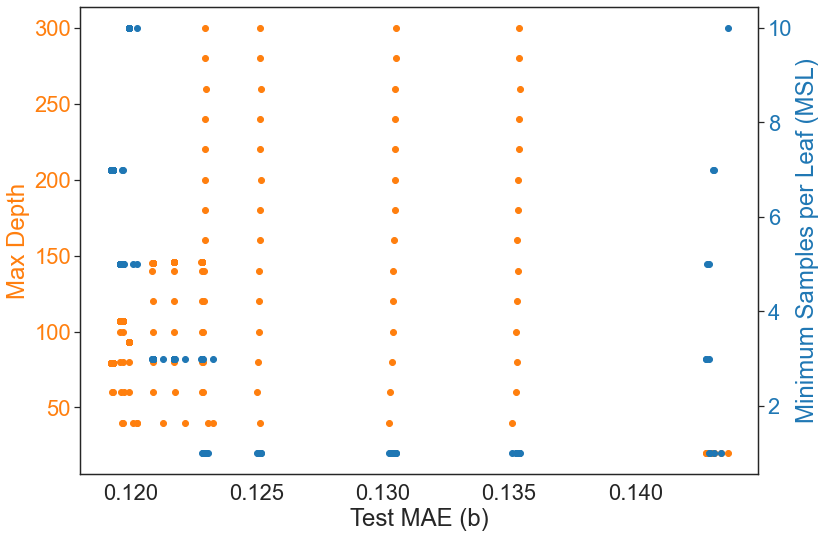

In [83]:
fig, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:orange'
ax1.set_xlabel('Test MAE (b)')
ax1.set_ylabel('Max Depth', color=color)
ax1.scatter(dt_results.test_mae, dt_results.max_depth, color=color, marker="o")
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Minimum Samples per Leaf (MSL)', color=color)  # we already handled the x-label with ax1
ax2.scatter(dt_results.test_mae, dt_results.msl, color=color, marker="o")
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("dt_mae.png", bbox_inches="tight", dpi=400)
plt.show()

In [21]:
knn_results[knn_results.test_mae == knn_results.test_mae.min()]

,id,train_mae,train_mse,train_evs,train_mae_m,train_r2,test_mae,test_mse,test_evs,test_mae_m,test_r2,training_time,model_path
7,8,0.025888,0.010984,0.985761,0,0.985761,0.118706,0.06384,0.915102,0.041627,0.915102,3.068391,C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data...


In [22]:
dt_results[dt_results.test_mae == dt_results.test_mae.min()]

,id,max_depth,mss,msl,train_mae,train_mse,train_evs,train_mae_m,train_r2,test_mae,test_mse,test_evs,test_mae_m,test_r2,model_path,training_time
78,78,79,10,7,0.094422,0.03806,0.948863,0.035937,0.948863,0.11924,0.058154,0.921184,0.046686,0.921184,C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data...,36.738931


In [27]:
import os

In [30]:
new_model_path_knn = "ML_Models/KNN/"
new_model_path_dt = "ML_Models/DT/"
knn_results["model_path"] = knn_results.model_path.apply(lambda x: os.path.join(new_model_path_knn, os.path.basename(x)))
dt_results["model_path"] = dt_results.model_path.apply(lambda x: os.path.join(new_model_path_dt, os.path.basename(x)))

In [31]:
path_to_best_train_model_KNN = knn_results[knn_results.train_mae == knn_results.train_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_train_model_KNN))
train_model_knn = load(path_to_best_train_model_KNN) 

path_to_best_test_model_KNN = knn_results[knn_results.test_mae == knn_results.test_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_test_model_KNN))
test_model_knn = load(path_to_best_test_model_KNN) 

path_to_best_train_model_DT = dt_results[dt_results.train_mae == dt_results.train_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_train_model_DT))
train_model_dt = load(path_to_best_train_model_DT) 

path_to_best_test_model_DT = dt_results[dt_results.test_mae == dt_results.test_mae.min()]["model_path"].values[0]
print("Loading model saved at: {}".format(path_to_best_test_model_DT))
test_model_dt = load(path_to_best_test_model_DT) 

Loading model saved at: ML_Models/KNN/neigh_model_k18.joblib
Loading model saved at: ML_Models/KNN/neigh_model_k8.joblib
Loading model saved at: ML_Models/DT/dt_model_md300_mss2_msl1.joblib
Loading model saved at: ML_Models/DT/dt_model_md140_mss10_msl7.joblib


In [84]:
# def make_chlorine_paper_figure(dt_model, knn_model, chlorine_data_dt, chlorine_data_knn, new_data_dt, new_data_knn, endf_cl, e_array):
    
#     fig, (ax1, ax2) = plt.subplots(2, figsize=(30,10))

#     chlorine_data_ext = exfor_utils.expanding_inference_dataset(chlorine_data_dt, 0, 0, False, 0, e_array=e_array)
#     chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_dt.Energy.min()]
#     ax1.plot(chlorine_data_ext.Energy, dt_model.predict(chlorine_data_ext.drop(columns=["Data"])), label="DT", linestyle="dashed", c="firebrick", linewidth=3)
#     ax1.scatter(chlorine_data_dt.Energy, chlorine_data_dt.Data, alpha=0.5, c='#1f77b4')
#     ax1.scatter(new_data_dt.Energy, new_data_dt.Data, alpha=1, c='#ff7f0e', marker="x")
#     ax1.plot(endf_cl.Energy, endf_cl.Data, alpha=0.5, c="orange")
#     ax1.legend(loc=3)
#     ax1.set_xlim([-2, 7.5])

#     chlorine_data_ext = exfor_utils.expanding_inference_dataset(chlorine_data_knn, 0, 0, False, 0, e_array=e_array)
#     chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_knn.Energy.min()]
#     ax2.plot(chlorine_data_ext.Energy, knn_model.predict(chlorine_data_ext.drop(columns=["Data"])), label="KNN", linestyle="dashed", c="firebrick", linewidth=3)
#     ax2.scatter(chlorine_data_knn.Energy, chlorine_data_knn.Data, alpha=0.5, c='#1f77b4', label="EXFOR")
#     ax2.scatter(new_data_knn.Energy, new_data_knn.Data, alpha=1, c='#ff7f0e', marker="x", label="New Measurements")
#     ax2.plot(endf_cl.Energy, endf_cl.Data, alpha=0.5, c="orange", label="ENDF")
#     ax2.legend(loc=3)

#     ax1.set(ylabel='Cross Section (b)')
#     ax2.set(ylabel='Cross Section (b)')
    
#     ax2.set(xlabel='Energy (eV)') 
    
# #     fig.text(0.5, 0.04, 'Energy (eV)', ha='center')
# #     fig.text(0.04, 0.5, 'Cross Section (b)', va='center', rotation='vertical')
# #     # plt.tight_layout()
# #     plt.tight_layout(w_pad=5.5, h_pad=5.0)
    
#     # plt.savefig("ML_Cl.png", dpi=500, bbox_inches="tight")

In [85]:
sns.set(font_scale=2.5)
sns.set_style("white")

In [102]:
def make_chlorine_paper_figure(dt_model, knn_model, chlorine_data_dt, chlorine_data_knn, new_data_dt, new_data_knn, endf_cl, e_array):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(30,20))

    chlorine_data_ext = exfor_utils.expanding_inference_dataset(chlorine_data_dt, 0, 0, False, 0, e_array=e_array)
    chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_dt.Energy.min()]
    
    ax1.plot(10**(chlorine_data_ext.Energy), 10**(dt_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="DT", linestyle="dashed", c="firebrick", linewidth=3)
    ax1.scatter(10**(chlorine_data_dt.Energy), 10**(chlorine_data_dt.Data), alpha=0.5, c='#1f77b4', label="EXFOR")
    ax1.scatter(10**(new_data_dt.Energy), 10**(new_data_dt.Data), alpha=1, c='#ff7f0e', s=250, marker="x", label="J.C.Batchelder (2019)")
    ax1.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.5, c="orange", label="ENDF")
    ax1.legend(loc=3)

    chlorine_data_ext = exfor_utils.expanding_inference_dataset(chlorine_data_knn, 0, 0, False, 0, e_array=e_array)
    chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_knn.Energy.min()]
    
    ax2.plot(10**(chlorine_data_ext.Energy), 10**(knn_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="KNN", linestyle="dashed", c="firebrick", linewidth=3)
    ax2.scatter(10**(chlorine_data_knn.Energy), 10**(chlorine_data_knn.Data), alpha=0.5, c='#1f77b4', label="EXFOR")
    ax2.scatter(10**(new_data_knn.Energy), 10**(new_data_knn.Data), alpha=1, s=250, c='#ff7f0e', marker="x", label="J.C.Batchelder (2019)")
    ax2.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.5, c="orange", label="ENDF")
    ax2.legend(loc=3)

    ax1.set(ylabel='Cross Section (b)')
    ax2.set(ylabel='Cross Section (b)')
    
    ax1.set(xlabel='Energy (eV)') 
    ax2.set(xlabel='Energy (eV)') 
    
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(10**-2, 10**7.5)
    ax2.set_xlim(10**-2, 10**7.5)

#     fig.text(0.5, 0.04, 'Energy (eV)', ha='center')
#     fig.text(0.04, 0.5, 'Cross Section (b)', va='center', rotation='vertical')
#     # plt.tight_layout()
#     plt.tight_layout(w_pad=5.5, h_pad=5.0)
    
    plt.savefig("ML_Cl.png", dpi=600, bbox_inches="tight")

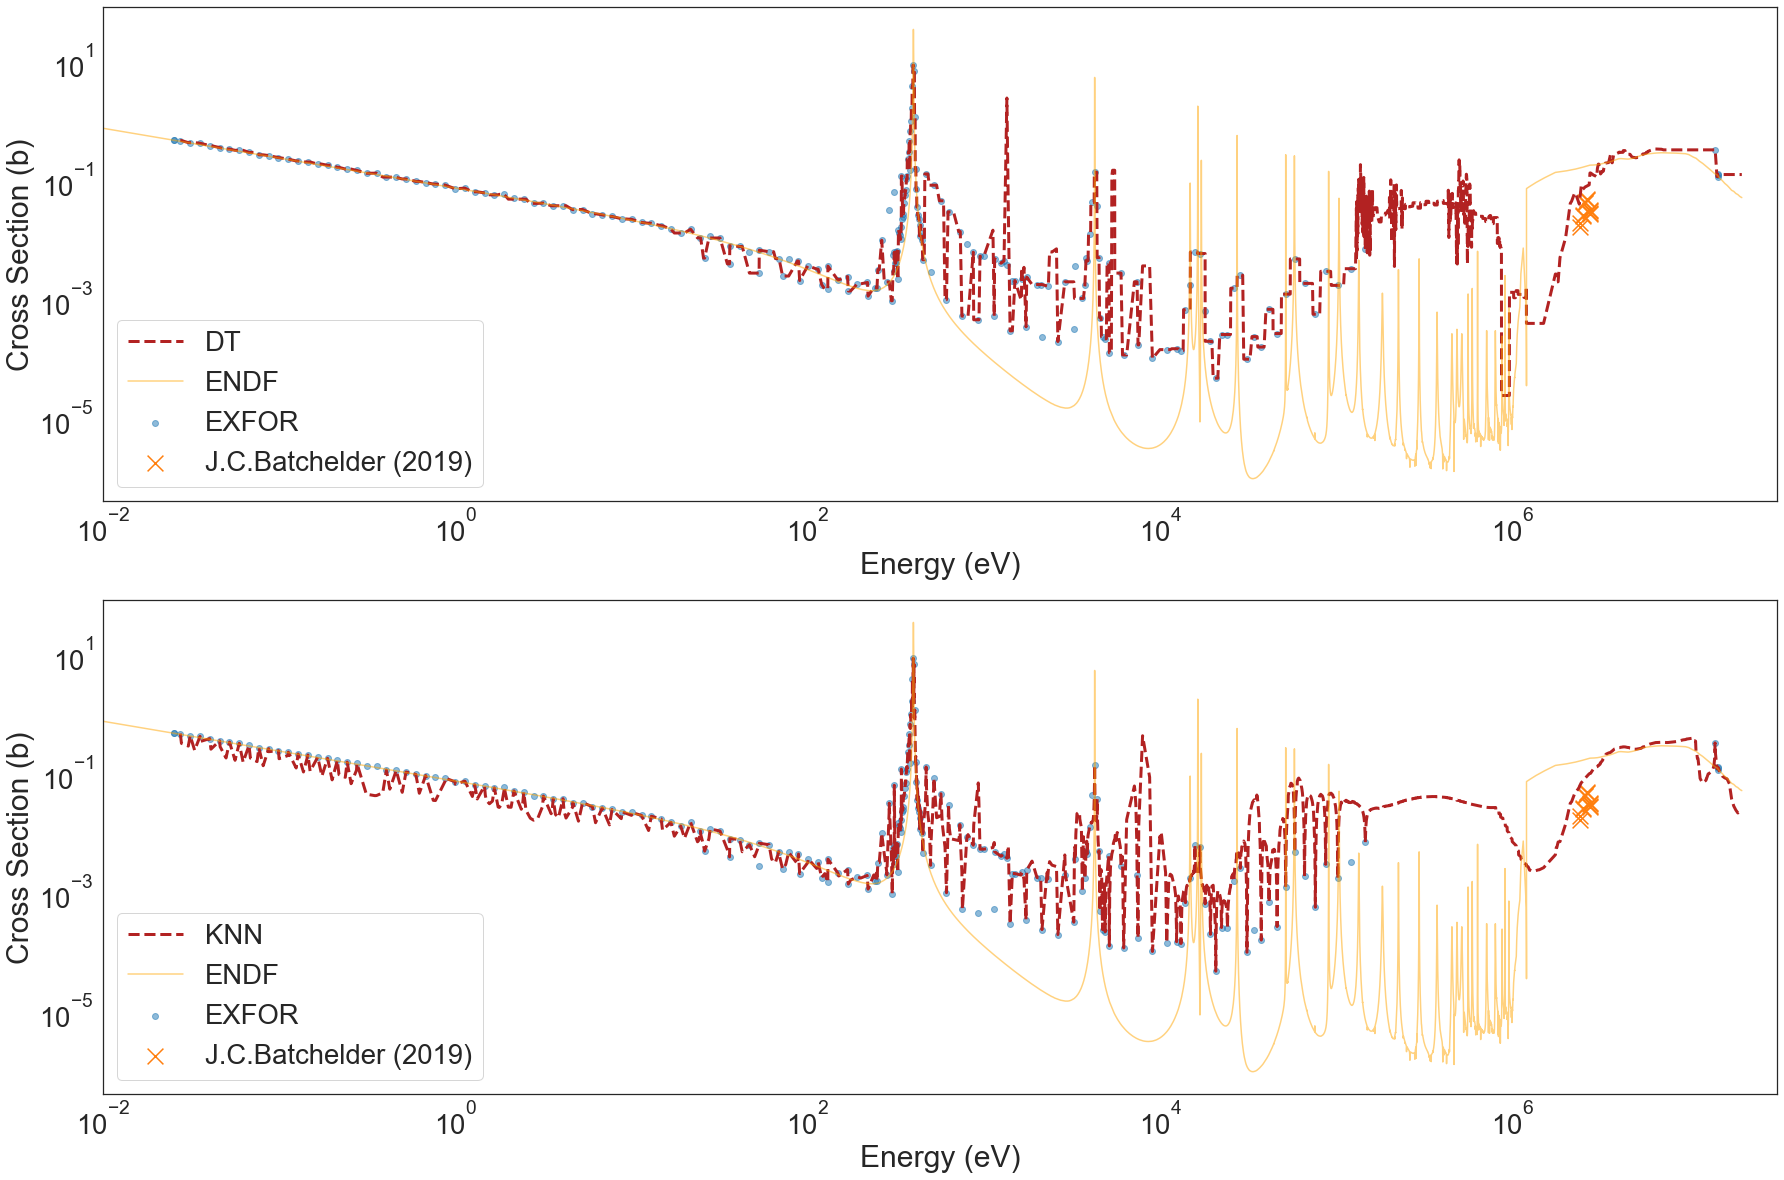

In [103]:
make_chlorine_paper_figure(train_model_dt, train_model_knn, chlorine_35_np_dt, chlorine_35_np_knn, 
                           new_cl_data_dt, new_cl_data_knn, endf_cl, ace_cl)

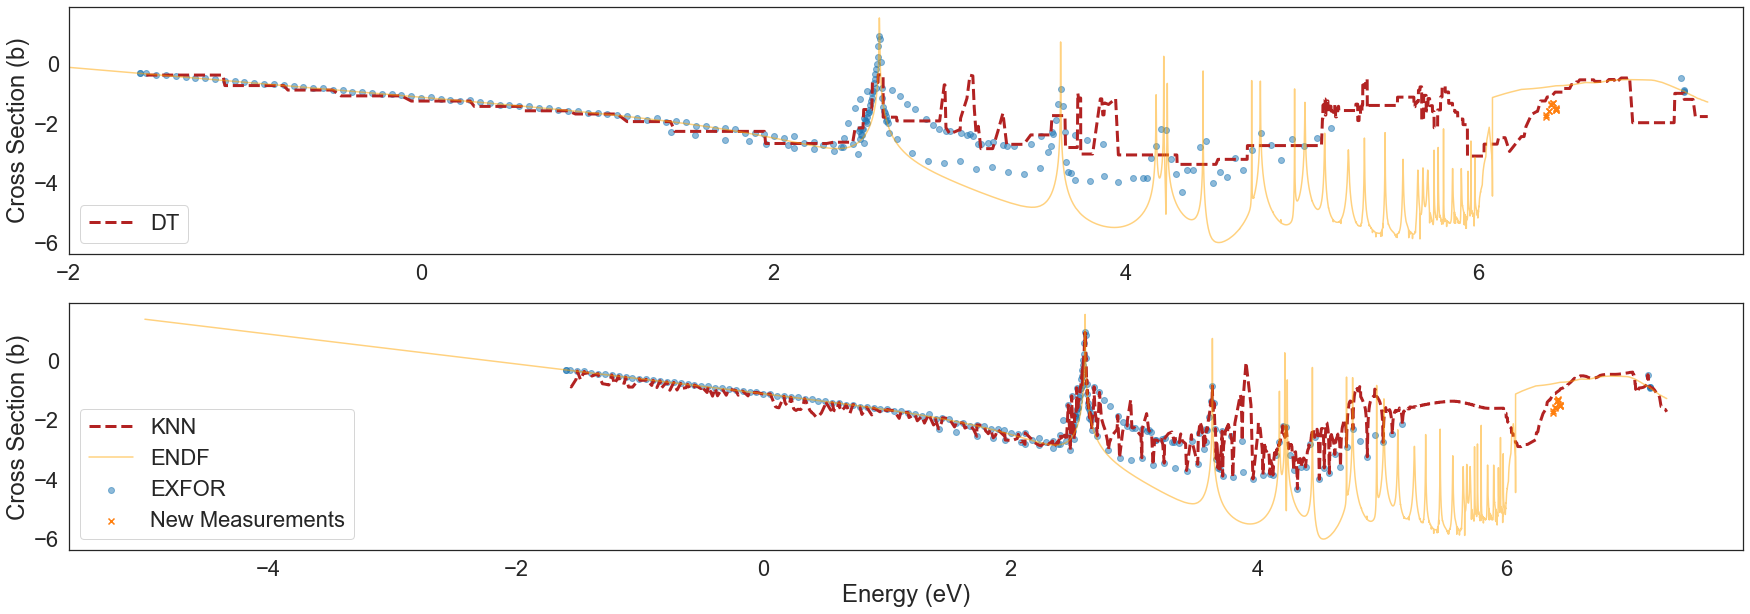

In [17]:
make_chlorine_paper_figure(test_model_dt, test_model_knn, chlorine_35_np_dt, chlorine_35_np_knn, 
                           new_cl_data_dt, new_cl_data_knn, endf_cl, ace_cl)

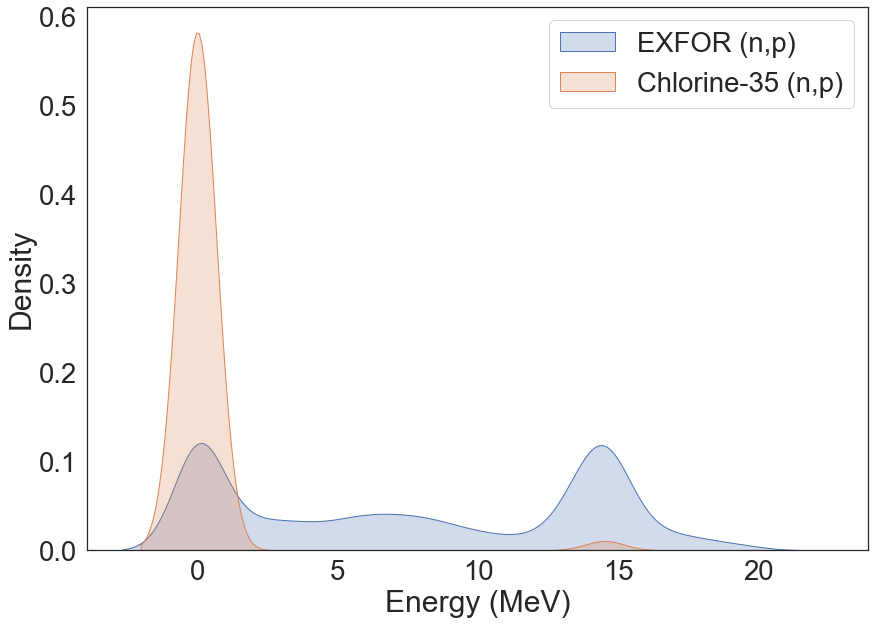

In [130]:
unlog_chlorine = chlorine_35_np_dt.copy()
unlog_chlorine["Energy"] = 10**chlorine_35_np_dt.Energy
unlog_chlorine["Energy"] = unlog_chlorine["Energy"] * 10**-6

unlog_df = df[df.MT_103 == 1].copy()
unlog_df["Energy"] = 10**unlog_df.Energy
unlog_df["Energy"] = unlog_df["Energy"] * 10**-6

plt.figure(figsize=(14,10))
sns.kdeplot(data=unlog_df, x="Energy", label="EXFOR (n,p)", fill=True)
sns.kdeplot(data=unlog_chlorine, x="Energy", label="Chlorine-35 (n,p)", fill=True)
plt.legend()
plt.xlabel("Energy (MeV)")
plt.savefig("bivariate_mt_103.png", dpi=600, bbox_inches="tight")

In [17]:
# %matplotlib qt
# import matplotlib.pyplot as plt

In [18]:
ml_grid = pd.read_csv("ML_GRID.csv")
u233_ml = pd.read_csv("U233_Data_ML.csv")

In [21]:
ml_grid

,Data_16,Data_17,Data_18,Data_37,Data_51,Data_52,Data_53,Data_54,Data_55,Data_56,...,Data_86,Data_87,Data_88,Data_91,Data_102,Data_4,Data_3,Data_101,Data_1,Data_2
0,0.000000,0.000000,26877.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2232.315000,0.000000,29109.835000,2232.315000,29157.207400,47.372400
1,0.000000,0.000000,25340.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2104.648000,0.000000,27445.008000,2104.648000,27489.828900,44.820900
2,0.000000,0.000000,24039.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1996.647000,0.000000,26036.617000,1996.647000,26079.287200,42.670200
3,0.000000,0.000000,22921.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1903.729000,0.000000,24824.939000,1903.729000,24865.765600,40.826600
4,0.000000,0.000000,21945.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1822.684000,0.000000,23768.074000,1822.684000,23807.298300,39.224300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8737,0.056734,0.045851,2.296800,0.149627,0.089681,0.039340,0.009014,0.000025,0.004165,0.000036,...,0.010878,0.010814,0.001975,0.062356,0.000155,0.257150,2.806318,0.000155,5.928545,3.122227
8738,0.055079,0.041571,2.296800,0.163561,0.089224,0.039059,0.008865,0.000024,0.004089,0.000036,...,0.010791,0.010729,0.001960,0.061695,0.000141,0.255056,2.812208,0.000141,5.881533,3.069325
8739,0.053518,0.037741,2.280800,0.176420,0.088789,0.038800,0.008731,0.000024,0.004018,0.000035,...,0.010690,0.010632,0.001942,0.061031,0.000130,0.252959,2.801567,0.000130,5.834610,3.033042
8740,0.052122,0.034419,2.214292,0.188032,0.088386,0.038567,0.008612,0.000024,0.003952,0.000035,...,0.010582,0.010529,0.001924,0.060303,0.000119,0.250845,2.739829,0.000119,5.788014,3.048185


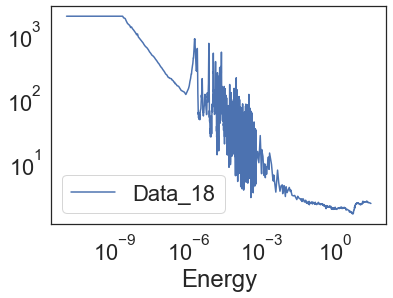

In [23]:
u233_ml.plot(x="Energy", y="Data_18")
plt.xscale('log')
plt.yscale('log')

In [23]:
exfor_mt1 = df[(df["Target_Protons"] == 92) & (df["MT_1"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt1.shape)
exfor_mt2 = df[(df["Target_Protons"] == 92) & (df["MT_2"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt2.shape)
exfor_mt3 = df[(df["Target_Protons"] == 92) & (df["MT_3"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt3.shape)
exfor_mt18 = df[(df["Target_Protons"] == 92) & (df["MT_18"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt18.shape)
exfor_mt101 = df[(df["Target_Protons"] == 92) & (df["MT_101"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt101.shape)
exfor_mt102 = df[(df["Target_Protons"] == 92) & (df["MT_102"] == 1) & (df["Target_Mass_Number"] == 233)].sort_values(by='Energy', ascending=True)
print(exfor_mt102.shape)

exfor_mt1[to_scale] = scaler.transform(exfor_mt1[to_scale])
exfor_mt2[to_scale] = scaler.transform(exfor_mt2[to_scale])
exfor_mt3[to_scale] = scaler.transform(exfor_mt3[to_scale])
exfor_mt18[to_scale] = scaler.transform(exfor_mt18[to_scale])
exfor_mt101[to_scale] = scaler.transform(exfor_mt101[to_scale])
exfor_mt102[to_scale] = scaler.transform(exfor_mt102[to_scale])

print(mean_absolute_error(neigh_all.predict(exfor_mt1.drop(columns=["Data"])), exfor_mt1.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt2.drop(columns=["Data"])), exfor_mt2.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt3.drop(columns=["Data"])), exfor_mt3.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt18.drop(columns=["Data"])), exfor_mt18.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt101.drop(columns=["Data"])), exfor_mt101.Data))
print(mean_absolute_error(neigh_all.predict(exfor_mt102.drop(columns=["Data"])), exfor_mt102.Data))

(33384, 49)
(261, 49)
(2, 49)
(94567, 49)
(7, 49)
(4588, 49)
0.11498025492377936
0.029138092878862425
0.04549226696177883
0.06519720707800516
0.17749248625297656
0.16909921184572574


In [ ]:
def get_errors_for_mt(mt_list, df, Z, A, el):
    mae_results = pd.DataFrame(columns=['MT', 'MAE'])
    for mt in mt_list:
        endf_mt = nuc_data.load_endf(el + str(int(A)), mt, log=True)
        exfor_mt = df[(df["Target_Protons"] == Z) & (df["MT_1"] == 1) & (df["Target_Mass_Number"] == A)]
        exfor_mt[to_scale] = scaler.transform(exfor_mt[to_scale])
        mt_mae = mean_absolute_error(neigh_all.predict(exfor_mt.drop(columns=["Data"])), exfor_mt.Data)
        mae_results["MT"] = mt
        mae_results["MAE"] = mt_mae
    return mae_results

In [24]:
endf_mt1 = nuc_data.load_endf("U233", "MT001", log=True)
endf_mt2  = nuc_data.load_endf("U233", "MT002", log=True)
endf_mt3  = nuc_data.load_endf("U233", "MT003", log=True)
endf_mt18 = nuc_data.load_endf("U233", "MT018", log=True)
endf_mt101  = nuc_data.load_endf("U233", "MT101", log=True)
endf_mt102  = nuc_data.load_endf("U233", "MT102", log=True)

C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT001.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (12617, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT002.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (5590, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT003.endfb8.0
Convering MeV to eV...
Finish reading ENDF data with shape:  (33329, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT018.endfb8.0
Convering MeV to eV...
Convering mb to b...
Finish reading ENDF data with shape:  (15345, 2)
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-MT101.endfb8.0
File does not exists.
C:\Users\Pedro\Desktop\ML_Nuclear_Data\ML_Data\ENDF_neutrons\U233\endfb8.0\tables\xs\n-U233-M

In [35]:
def get_error_endf_new(endf, new_data):
    endf_copy = endf.copy()
    indexes = np.arange(len(endf), len(endf) + len(new_data))
    new_data.index = indexes
    energy_interest = new_data[["Energy"]]
    energy_interest["Data"] = np.nan
    endf_copy = endf_copy.append(energy_interest, ignore_index=False)
    endf_copy = endf_copy.sort_values(by=['Energy'])
    endf_copy["Data"] = endf_copy["Data"].interpolate()

    # Measuring metrics on predictions.
    print("NEW DATA: ENDF vs EXFOR:")
    print(mean_absolute_error(new_data[["Data"]], endf_copy[["Data"]].loc[indexes]))
    
    # print(endf_copy[["Data"]].loc[indexes])

In [37]:
get_error_endf_new(endf_mt1, exfor_mt1)
get_error_endf_new(endf_mt2, exfor_mt2)
get_error_endf_new(endf_mt3, exfor_mt3)
get_error_endf_new(endf_mt18, exfor_mt18)
get_error_endf_new(endf_mt102, exfor_mt102)

NEW DATA: ENDF vs EXFOR:
0.12225468523644997
NEW DATA: ENDF vs EXFOR:
0.06453464913682203
NEW DATA: ENDF vs EXFOR:
0.05256837778722229
NEW DATA: ENDF vs EXFOR:
0.09105713111655128
NEW DATA: ENDF vs EXFOR:
0.22099112919514152


Extracting samples from dataframe.
Scaling dataset...
EXFOR extracted DataFrame has shape:  (94567, 49)


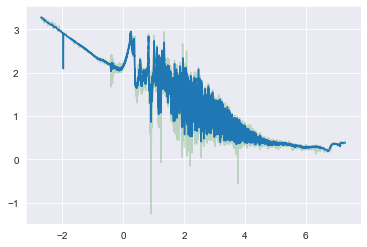

In [149]:
mt_18 = exfor_utils.make_predictions_from_df(92, 233, "MT_18", df, neigh_all, 
                                              None, scaler, to_scale, log=True, show=True)

# Predicting using ACE Energy Grid

to save are:

- MT102
- MT18
- MT1
- MT2
- MT3

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 49)
Expanded Dataset has shape:  (21591, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (215, 49)


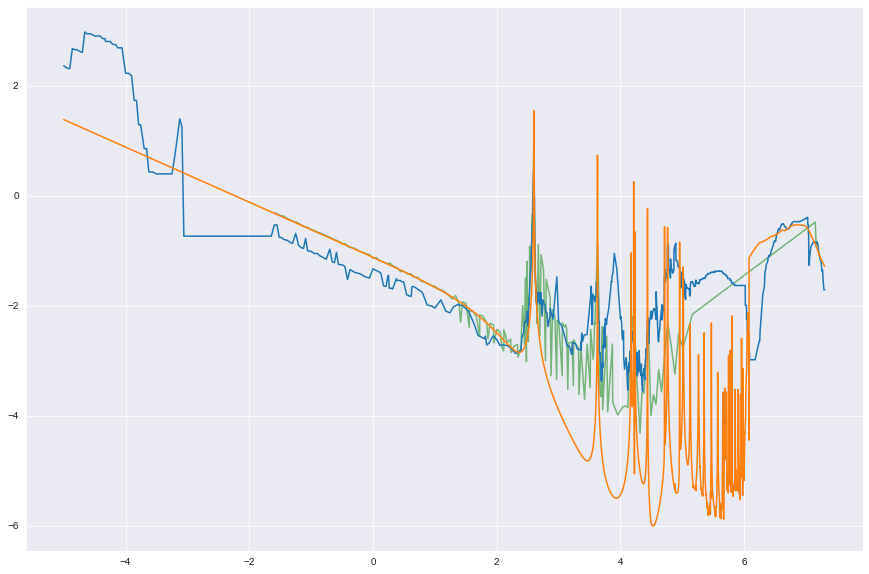

In [268]:
plt.figure(figsize=(15,10))
cl_mt_101 = exfor_utils.make_predictions_w_energy(ace_cl, 17, 35, "MT_103", df, neigh_all, 
                                              None, scaler, to_scale, log=True, show=True)
plt.plot(endf_cl.Energy, endf_cl.Data)

Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (94567, 49)
Expanded Dataset has shape:  (8742, 48)
Scaling dataset...
Extracting samples from dataframe.
EXFOR extracted DataFrame has shape:  (94567, 49)


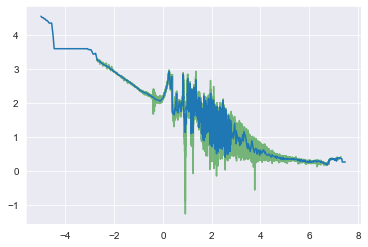

In [159]:
mt_18 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_18", df, neigh_all, 
                                              None, scaler, to_scale, log=True, show=True)

In [256]:
# mt_102 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_102", df, neigh_all, 
#                                                None, scaler, to_scale, log=True, show=True)

# mt_1 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_1", df, neigh_all, None, 
#                                              scaler, to_scale, log=True, show=True)
# plt.show()
# plt.close()
# mt_2 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_2", df, neigh_all, 
#                                              None, scaler, to_scale, log=True, show=True)
# plt.show()
# plt.close()
# mt_3 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_3", df, neigh_all, 
#                                              None, scaler, to_scale, log=True, show=True)
# plt.plot(endf_u_nonelastic.Energy, endf_u_nonelastic.Data)

# mt_101 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_101", df, neigh_all, 
#                                                None, scaler, to_scale, log=True, show=True)

# mt_1 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_1", df, neigh_all, None, 
#                                              scaler, to_scale, log=True, show=True)
# plt.show()
# plt.close()
# mt_2 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_2", df, neigh_all, 
#                                              None, scaler, to_scale, log=True, show=True)
# plt.show()
# plt.close()
# mt_3 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_3", df, neigh_all, 
#                                              None, scaler, to_scale, log=True, show=True)
# plt.plot(endf_u_nonelastic.Energy, endf_u_nonelastic.Data)

# mt_101 = exfor_utils.make_predictions_w_energy(ace_u, 92, 233, "MT_101", df, neigh_all, 
#                                                None, scaler, to_scale, log=True, show=True)

In [177]:
# data_interest = pd.DataFrame({"Energy":ace_u})

# data_interest["Data_18"] = mt_18
# data_interest["Data_102"] = mt_102
# data_interest["Data_1"] = mt_1
# data_interest["Data_2"] = mt_2
# data_interest["Data_3"] = mt_3

# # data_interest.to_csv("U233_Data_ML.csv", index=False)